In [13]:
import torch
import torch.nn as nn
import time
import utils
import torch.nn.functional as F

In [14]:
device  = torch.device("cuda")

torch.Size([50000, 3, 32, 32])
torch.Size([10000, 3, 32, 32])
tensor(0.4734)
tensor(0.2516)


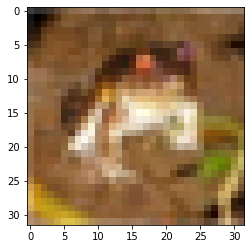

In [15]:
from utils import check_cifar_dataset_exists

data_path = check_cifar_dataset_exists()

train_data = torch.load(data_path + "cifar/train_data.pt")
train_label = torch.load(data_path + "cifar/train_label.pt")
test_data = torch.load(data_path+"cifar/test_data.pt")
test_label = torch.load(data_path+"cifar/test_label.pt")

# Data overview
print(train_data.size())
print(test_data.size())
mean = train_data.mean().to(device)
std = train_data.std().to(device)
print(mean.cpu())
print(std.cpu())

image = train_data[0]
utils.show(image)

In [16]:
class vgg(nn.Module):
    def __init__(self):
        super(vgg,self).__init__()
        # First block
        self.conv1a = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv1b = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2,2)
        # Second block
        self.conv2a = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv2b = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2,2)
        #Third block
        self.conv3a = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3b = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(2,2)
        #Fourth block
        self.con4a = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool2d(2,2)
        #Fifth block
        self.linear1 = nn.Linear(2048, 4096)
        self.linear2 = nn.Linear(4096, 4096)
        self.linear3 = nn.Linear(4096, 10)
    
    def forward(self,x):
        # Block 1
        x = self.conv1a(x)
        x = F.relu(x)
        x = self.conv1b(x)
        x = F.relu(x)
        x = self.pool1(x)
        # Block 2
        x = self.conv2a(x)
        x = F.relu(x)
        x = self.conv2b(x)
        x = F.relu(x)
        x = self.pool2(x)
        # Block 3
        x = self.conv3a(x)
        x = F.relu(x)
        x = self.conv3b(x)
        x = F.relu(x)
        x = self.pool3(x)
        # Block 4
        x = self.con4a(x)
        x = F.relu(x)
        x = self.pool4(x)
        # Block 4
        x = x.view(-1, 2048)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.linear3(x)
        
        return x


### Setting criterion

In [17]:
criterion = nn.CrossEntropyLoss()
bs = 128
lr = 0.25

# Evaluating function
def eval_on_test_data():
    running_error = 0
    num_batches = 0
    for count in range(0, 10000, bs):
        minibatch_data = test_data[count: count+bs].to(device)
        minibatch_label = test_label[count: count+bs].to(device)
        inputs = (minibatch_data-mean)/std
        scores = net(inputs)
        error = utils.get_error(scores, minibatch_label)
        running_error += error.item()
        num_batches += 1

    total_error = running_error/num_batches*100
    print("Error on test set {:.2f}%".format(total_error))

### Training model

In [19]:
net = vgg().to(device)

for epoch in range(20):
    if epoch in [10,14,20]:
        lr = lr/2
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    shuffled_indices = torch.randperm(50000)
    running_loss = 0
    running_error = 0
    num_batches = 0

    for count in range(0, 50000, bs):
        optimizer.zero_grad()
        minibatch_data = train_data[count:count+bs].to(device)
        minibatch_label = train_label[count:count+bs].to(device)

        inputs = (minibatch_data-mean)/std
        inputs.requires_grad_()

        scores = net(inputs)
        loss = criterion(scores, minibatch_label)
        loss.backward()
        optimizer.step()

        # Calculating stat
        running_loss += loss.item()
        error = utils.get_error(scores, minibatch_label)
        running_error += error.item()
        num_batches += 1

    total_error = running_error/num_batches*100
    total_loss = running_loss/num_batches
    print("Epoch:{}, Error:{:.2f}%, Loss:{:.2f}".format(epoch, total_error, total_loss))
    eval_on_test_data()
    print("--------------")

Epoch:0, Error:87.47%, Loss:2.27
Error on test set 80.92%
--------------
Epoch:1, Error:71.61%, Loss:1.91
Error on test set 63.94%
--------------
Epoch:2, Error:58.36%, Loss:1.59
Error on test set 56.57%
--------------
Epoch:3, Error:46.87%, Loss:1.29
Error on test set 40.88%
--------------
Epoch:4, Error:36.17%, Loss:1.02
Error on test set 33.99%
--------------
Epoch:5, Error:28.18%, Loss:0.80
Error on test set 30.52%
--------------
Epoch:6, Error:23.18%, Loss:0.67
Error on test set 28.13%
--------------
Epoch:7, Error:18.22%, Loss:0.52
Error on test set 26.11%
--------------
Epoch:8, Error:14.87%, Loss:0.42
Error on test set 26.03%
--------------
Epoch:9, Error:11.66%, Loss:0.33
Error on test set 24.85%
--------------
Epoch:10, Error:4.62%, Loss:0.13
Error on test set 23.02%
--------------
Epoch:11, Error:1.70%, Loss:0.05
Error on test set 22.66%
--------------
Epoch:12, Error:1.53%, Loss:0.04
Error on test set 24.06%
--------------
Epoch:13, Error:1.47%, Loss:0.04
Error on test set 

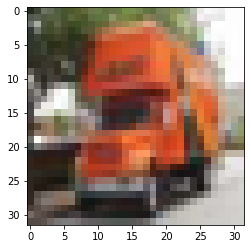

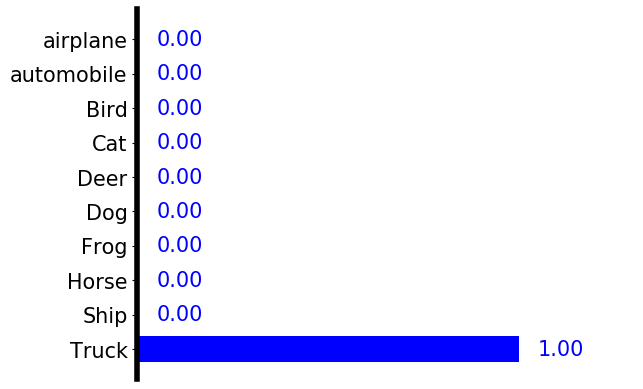

In [25]:
import random
idx = random.randint(0, 10000-1)
image = test_data[idx]
utils.show(image)

image = image.to(device)
image = (image-mean)/std
image = image.view(-1, 3, 32, 32)

scores = net(image)
probs = F.softmax(scores, dim=1)
utils.show_prob_cifar(probs.cpu())
